In [41]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy import wcs
import matplotlib.pyplot as plt



In [135]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    emission = 0
    div = 0
    hist = []
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                hist.append(hmap[i,j].value)
                div +=1
    return  np.array(hist)*hmap.unit

In [110]:
hdu = fits.open('moo-alex.fits')

In [111]:
hdu[0].header
w = wcs.WCS(hdu[0].header)
print(w)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 30.63450833333  -38.5  3000000000.0  1.0  
CRPIX : 1153.0  941.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0002777777777778  0.0002777777777778  2072094276.615  1.0  
NAXIS : 723  724  1  1


In [112]:
pixel_size = wcs.utils.proj_plane_pixel_scales(w)[0]*u.deg

vmap = hdu[0].data[0][0]
print(vmap)

[[ 1.26215018e-04  1.34118134e-04  1.12799018e-04 ... -1.72963832e-04
  -1.40914330e-04 -8.94606928e-05]
 [ 1.87350102e-04  1.44290025e-04 -4.24434575e-06 ... -2.16183893e-04
  -1.37840136e-04 -1.02897524e-04]
 [ 1.54279041e-04  1.30654706e-04 -6.57793644e-05 ... -2.44269992e-04
  -2.09863811e-06  4.96602624e-05]
 ...
 [-1.30169021e-04 -1.37651004e-05  1.04401901e-04 ... -1.77732363e-04
  -1.84816861e-04  1.43121360e-05]
 [-2.00519440e-04 -1.11012278e-05  1.22414727e-04 ... -1.67367078e-04
  -7.58731767e-05  8.16960091e-05]
 [-2.51881633e-04 -1.70219035e-04  3.70106100e-05 ... -3.48010071e-05
   2.94965193e-05 -1.27749490e-05]]


In [113]:
fwhm = 2.5*u.arcsec

omega_B = np.pi *(fwhm/2)**2/np.log(2)
vmap = (vmap*u.Jy/u.beam).to(u.MJy/u.sr, equivalencies=u.beam_angular_area(omega_B))
print(vmap)

[[ 0.75825775  0.805737    0.67765886 ... -1.039109   -0.8465663
  -0.53745   ]
 [ 1.1255369   0.8668463  -0.02549861 ... -1.2987608  -0.8280976
  -0.618174  ]
 [ 0.92685705  0.7849299  -0.3951805  ... -1.4674927  -0.01260792
   0.2983423 ]
 ...
 [-0.78201205 -0.08269613  0.6272118  ... -1.0677568  -1.1103181
   0.08598254]
 [-1.204654   -0.06669247  0.73542684 ... -1.0054855  -0.45582074
   0.49080238]
 [-1.5132209  -1.0226192   0.22234741 ... -0.20907284  0.17720525
  -0.07674763]] MJy / sr


In [114]:
pixel_area = (pixel_size**2).to(u.sr)

print(pixel_area)

2.3504430539101646e-11 sr


In [124]:
vmap = vmap*pixel_area
print(vmap[0,0])

1.7822417153201542e-11 MJy


[[ 1.78224172e-11  1.89383908e-11  1.59279864e-11 ... -2.44236662e-11
  -1.98980589e-11 -1.26324567e-11]
 [ 2.64551055e-11  2.03747297e-11 -5.99330427e-13 ... -3.05266333e-11
  -1.94639617e-11 -1.45298287e-11]
 [ 2.17852472e-11  1.84493306e-11 -9.28849272e-12 ... -3.44925824e-11
  -2.96341944e-13  7.01236551e-12]
 ...
 [-1.83807483e-11 -1.94372556e-12  1.47422560e-11 ... -2.50970147e-11
  -2.60973951e-11  2.02097063e-12]
 [-2.83147065e-11 -1.56756856e-12  1.72857891e-11 ... -2.36333661e-11
  -1.07138074e-11  1.15360308e-11]
 [-3.55673963e-11 -2.40360839e-11  5.22614937e-12 ... -4.91413811e-12
   4.16510836e-12 -1.80390945e-12]] MJy


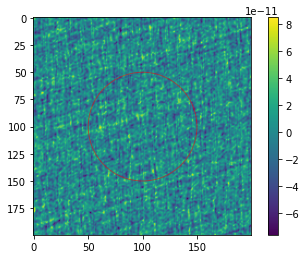

In [125]:
print(vmap)
stamp = Cutout2D(vmap, (int(723/2),int(724/2)), 200. , mode = 'strict')

fig, axes = plt.subplots()

plt.imshow(stamp.data.value)
draw_circle = plt.Circle((100, 100), 50, color = 'r',fill=False, alpha = 0.5)

plt.colorbar()

axes.set_aspect(1)
axes.add_artist(draw_circle)

In [145]:
cent_em = central_emission(stamp.data, int(100), pixel_size.to(u.arcmin).value, 1.0)


#plt.hist(cent_em.value)
#plt.hist(stamp.data.value*10**11)
#apature_area = np.pi*(1.0*u.arcmin)**2
#average_flux = cent_em[0]/apature_area

print(np.mean(cent_em), np.std(cent_em))
print(np.mean(stamp.data), np.std(stamp.data))



-9.8360474496198e-14 MJy 1.9589484548387937e-11 MJy
7.625681092441813e-14 MJy 1.9470109552388593e-11 MJy
3.508986720981988e-12 MJy / sr
